In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
from pandas import Series, DataFrame
# display plots in this notebook
%matplotlib inline
# set display defaults
#plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
from helper import *

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center", 
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
features_name = 'siamese'
n_features = 4096*3
n_samples_per_fold = 1
dataset = 1

In [5]:
def load_features(video):
    with open(os.path.join('./data/ArrowDataAll', video, 'features-' + features_name + '.csv'), 'r') as f:
        X = np.loadtxt(f, delimiter = ',')
    with open(os.path.join('./data/ArrowDataAll', video, 'labels-' + features_name + '.csv'), 'r') as f:
        y = np.loadtxt(f, delimiter = ',')
    video_names_with_multitude = [video] * len(y)
    return X, y, video_names_with_multitude

In [6]:
train_list, test_list = load_list('./data', dataset = dataset)

In [7]:
X_train = np.empty((0, n_features))
y_train = np.empty(0)
video_train = []
for video in train_list:
    if train_list.index(video) % 10 == 0:
        print train_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_train = np.append(X_train, X, axis = 0)
    y_train = np.append(y_train, y, axis = 0)
    video_train.extend(video_names_with_multitude)

1
11
21
31
41
51
61
71
81
91
101
111


In [8]:
X_test = np.empty((0, n_features))
y_test = np.empty(0)
video_test = []
for video in test_list:
    if test_list.index(video) % 10 == 0:
        print test_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_test = np.append(X_test, X, axis = 0)
    y_test = np.append(y_test, y, axis = 0)
    video_test.extend(video_names_with_multitude)

1
11
21
31
41
51


## Feature importance

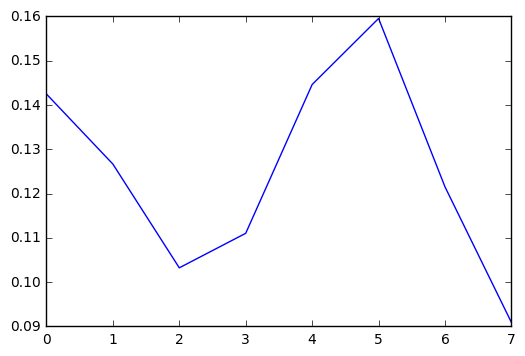

In [48]:
clf = RandomForestClassifier(n_jobs = -1, n_estimators=100)
clf.fit(X_train, y_train)
plt.plot(clf.feature_importances_)
plt.savefig('../report/figs/importance-f' + str(features_name) + '-d' + str(dataset) + '.pdf')

In [9]:
#clf = RandomForestClassifier(n_jobs=-1, n_estimators=100)
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(n_jobs=-1)
clf = SVC(C = 100, kernel = 'linear')
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [118]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':['linear', 'rbf'], 'C':[0.001, 0.01, 0.1, 1, 10, 100]}
#svc = SVC()
#clf = GridSearchCV(svc, parameters, n_jobs = -1)
#clf.fit(X_train, y_train)

In [10]:
print clf.score(X_test, y_test)

0.616666666667


In [11]:
y_predict = clf.predict(X_test)

In [12]:
y_predict[y_predict == 0] = -1
y_test[y_test == 0] = -1

In [13]:
df = DataFrame(Series(y_test))
df[1] = Series(y_predict)
df[2] = Series(video_test)
df.columns = ['true', 'predict', 'video']

In [14]:
fold = [['A']*n_samples_per_fold + ['B']*n_samples_per_fold + ['C']*n_samples_per_fold + ['D']*n_samples_per_fold]*60

In [15]:
import itertools
fold = list(itertools.chain(*fold))
df['fold'] = Series(fold)

In [16]:
df

,true,predict,video,fold
0,1.0,1.0,F_ebcfFg2ihYw,A
1,1.0,1.0,F_ebcfFg2ihYw,B
2,-1.0,-1.0,F_ebcfFg2ihYw,C
3,-1.0,-1.0,F_ebcfFg2ihYw,D
4,1.0,-1.0,F__18hsqaDrHs,A
5,1.0,-1.0,F__18hsqaDrHs,B
6,-1.0,1.0,F__18hsqaDrHs,C
7,-1.0,1.0,F__18hsqaDrHs,D
8,1.0,1.0,F_MTXhdrkEtoE,A
9,1.0,1.0,F_MTXhdrkEtoE,B


In [17]:
dfg = df.groupby(['video', 'fold']).mean().unstack()

In [18]:
dfg

true                predict               
fold             A    B    C    D       A    B    C    D
video                                                   
B1ADMcXAQCzo0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0
B1RsaXI-SKchA -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0
B1U5XS34QmUuI -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0
B1mOABN2abDq0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0
B1uglCr8ueyv8 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0
B2ADMcXAQCzo0 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0
B301TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0
B401TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0
B5X6jprOZ29wY -1.0 -1.0  1.0  1.0     1.0 -1.0 -1.0  1.0
F_05gGCvIopwE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_2NOQEJKLqks  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0
F_3DL_97x0dpQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_3c66YWCXdbU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_69RNNex-sig  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_6ClKTIhJizQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_6d6oBTmEbRM  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_94HqFht60Ek  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_EIh4VpXQ8HU  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_EbU7VPY4QIA  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_FaAjPRKXXv0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_FriaMvobUi0  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_G4VKPR67xYs  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_HFkYJofKBis  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_IBp5Aip2Vw0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_MTXhdrkEtoE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_O2VWbZIrMuw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_PosKL3to6l8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_Rv0sbR0lbDg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_SyO3YwrsJPg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_W8X7EFqVqNc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_XDpOtZ-sdQE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F__18hsqaDrHs  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F__RiKnRbBhtQ  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_aDEecz10DnY  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_b-MbEx1Iqj8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_bYepd01KDFw  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_cCMzlrpWHgo  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0
F_dhfcutcvsLU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_ebcfFg2ihYw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_fPZNvBcoOtE  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_fc8LngsvxUc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_gQXKFNJBgIc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_hyGJBV1xnJI  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_jmgV3OFn0aE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_k7viIK45xGQ  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_kJGQy-j3Nx4  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_kWetGqX9uFc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_kxCEpfTSfJU  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0
F_lanCzRFNoy8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_n1cCs-S5EKc  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0
F_n4MsOeSmwbs  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_oB2W0HIgpHg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_pZcB4oJ5jsc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_pdy9isqFDxE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_qVH7ZUbowMU  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0
F_tfMMAwlD7gs  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_uJzAPp8C2zA  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0
F_uvTMZmUdSsc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_x90_QK5U6WY  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0
F_y7-0L0kFnqA  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0

In [19]:
dfg['gt'] = dfg.apply(lambda x: (x['true']['A'] + x['true']['B']- x['true']['C']-x['true']['D']) > 0, axis = 1)
dfg['my'] = dfg.apply(lambda x: (x['predict']['A'] + x['predict']['B']- x['predict']['C']-x['predict']['D'])>=0, axis = 1)

In [20]:
dfg

true                predict                    gt     my
fold             A    B    C    D       A    B    C    D              
video                                                                 
B1ADMcXAQCzo0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False
B1RsaXI-SKchA -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0  False   True
B1U5XS34QmUuI -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True
B1mOABN2abDq0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False
B1uglCr8ueyv8 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True
B2ADMcXAQCzo0 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True
B301TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0  False   True
B401TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False
B5X6jprOZ29wY -1.0 -1.0  1.0  1.0     1.0 -1.0 -1.0  1.0  False   True
F_05gGCvIopwE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_2NOQEJKLqks  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True
F_3DL_97x0dpQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_3c66YWCXdbU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_69RNNex-sig  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_6ClKTIhJizQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_6d6oBTmEbRM  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_94HqFht60Ek  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_EIh4VpXQ8HU  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_EbU7VPY4QIA  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_FaAjPRKXXv0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_FriaMvobUi0  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_G4VKPR67xYs  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_HFkYJofKBis  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_IBp5Aip2Vw0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_MTXhdrkEtoE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_O2VWbZIrMuw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_PosKL3to6l8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_Rv0sbR0lbDg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_SyO3YwrsJPg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_W8X7EFqVqNc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_XDpOtZ-sdQE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F__18hsqaDrHs  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F__RiKnRbBhtQ  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_aDEecz10DnY  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_b-MbEx1Iqj8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_bYepd01KDFw  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_cCMzlrpWHgo  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True
F_dhfcutcvsLU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_ebcfFg2ihYw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_fPZNvBcoOtE  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False
F_fc8LngsvxUc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_gQXKFNJBgIc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_hyGJBV1xnJI  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_jmgV3OFn0aE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_k7viIK45xGQ  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_kJGQy-j3Nx4  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_kWetGqX9uFc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_kxCEpfTSfJU  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True
F_lanCzRFNoy8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_n1cCs-S5EKc  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True
F_n4MsOeSmwbs  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True
F_oB2W0HIgpHg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_pZcB4oJ5jsc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True
F_pdy9isqFDxE  1.0  1.0 -1.0 -1.0     

In [21]:
dfg['good'] = dfg['gt'] == dfg['my']

In [22]:
dfg

true                predict                    gt     my   good
fold             A    B    C    D       A    B    C    D                     
video                                                                        
B1ADMcXAQCzo0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False   True
B1RsaXI-SKchA -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0  False   True  False
B1U5XS34QmUuI -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True  False
B1mOABN2abDq0 -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False   True
B1uglCr8ueyv8 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True  False
B2ADMcXAQCzo0 -1.0 -1.0  1.0  1.0     1.0  1.0 -1.0 -1.0  False   True  False
B301TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0  1.0  1.0 -1.0  False   True  False
B401TL9bUWr6I -1.0 -1.0  1.0  1.0    -1.0 -1.0  1.0  1.0  False  False   True
B5X6jprOZ29wY -1.0 -1.0  1.0  1.0     1.0 -1.0 -1.0  1.0  False   True  False
F_05gGCvIopwE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_2NOQEJKLqks  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True   True
F_3DL_97x0dpQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_3c66YWCXdbU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_69RNNex-sig  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_6ClKTIhJizQ  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_6d6oBTmEbRM  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_94HqFht60Ek  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_EIh4VpXQ8HU  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_EbU7VPY4QIA  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_FaAjPRKXXv0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_FriaMvobUi0  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_G4VKPR67xYs  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_HFkYJofKBis  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_IBp5Aip2Vw0  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_MTXhdrkEtoE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_O2VWbZIrMuw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_PosKL3to6l8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_Rv0sbR0lbDg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_SyO3YwrsJPg  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_W8X7EFqVqNc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_XDpOtZ-sdQE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F__18hsqaDrHs  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F__RiKnRbBhtQ  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_aDEecz10DnY  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_b-MbEx1Iqj8  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_bYepd01KDFw  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_cCMzlrpWHgo  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True   True
F_dhfcutcvsLU  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_ebcfFg2ihYw  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_fPZNvBcoOtE  1.0  1.0 -1.0 -1.0    -1.0 -1.0  1.0  1.0   True  False  False
F_fc8LngsvxUc  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_gQXKFNJBgIc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_hyGJBV1xnJI  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_jmgV3OFn0aE  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_k7viIK45xGQ  1.0  1.0 -1.0 -1.0    -1.0  1.0  1.0 -1.0   True   True   True
F_kJGQy-j3Nx4  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_kWetGqX9uFc  1.0  1.0 -1.0 -1.0     1.0  1.0 -1.0 -1.0   True   True   True
F_kxCEpfTSfJU  1.0  1.0 -1.0 -1.0     1.0 -1.0 -1.0  1.0   True   True   True
F_lanCzRFNoy8  1.0  1.0 -1.0 -1.0   

In [23]:
dfg['good'].mean()

0.69999999999999996

In [41]:
cm = confusion_matrix(dfg['gt'], dfg['my'])

Normalized confusion matrix
[[ 0.5         0.5       ]
 [ 0.19230769  0.80769231]]


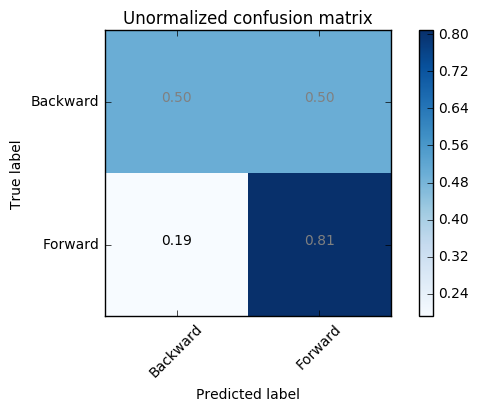

In [282]:
plot_confusion_matrix(cm, classes=['Backward', 'Forward'], normalize=True,
                      title='Unormalized confusion matrix')
plt.savefig('../report/figs/cm-' + str(features_name) + '-d' + str(dataset) + '.pdf')